<a href="https://colab.research.google.com/github/sturu1/FRI/blob/master/2020_08_07_%EC%98%A4%EC%A0%84%EC%88%98%EC%97%85_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GAN

https://ebbnflow.tistory.com/167


In [39]:
#자주사용하는 코드임
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [40]:
coding_size = 30

generator = keras.models.Sequential([
                                     keras.layers.Dense(100, activation = 'selu', input_shape = [coding_size]),
                                     keras.layers.Dense(150, activation = 'selu'),
                                     keras.layers.Dense(28 * 28, activation = 'sigmoid'),
                                     keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
                                        keras.layers.Flatten(input_shape = [28, 28]),#2차원으로 받는다.
                                        keras.layers.Dense(150, activation = 'selu'),#activation 잇어야지 활성화된다.
                                        keras.layers.Dense(100, activation = 'selu'),
                                        keras.layers.Dense(1, activation = 'sigmoid')#GAN에선 마지막은 sigmoid 사용하는게 결과가 좋다.
])

gan = keras.models.Sequential([generator, discriminator])#하나로 묶인다.

In [41]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False

In [42]:
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')#묶여잇는걸 전체 다 학습할거임 #네트워크 구성 끝

In [43]:
#데이터 셋 불러오기
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255 #0~1사이로 바뀜
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [44]:
batch_size = 32
#중요??
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [45]:
print(len(dataset))

1718


In [58]:
def plot_multiple_images(images, n_cols = None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape [-1] == 1:
    images = np.squeeze(images, axis = -1)
  plt.figure(figsize = (n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap = 'binary')
    plt.axis("off")

In [59]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs =50):#보통 이미지에선 10~30?이 좋다
  #처음엔 초기값 정해주는게 좋다
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for X_batch in dataset:
      noise = tf.random.normal(shape = [batch_size, coding_size])
      generated_images = generator(noise)#가짜이미지?
      X_fake_and_real = tf.concat([generated_images, X_batch],axis = 0)      
      y1 = tf.constant([[0, ]] * batch_size + [[1, ]] * batch_size)#X_fake_and_real에 대한 정답 데이터      
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      #discriminator 학습이 됫음

      noise = tf.random.normal(shape = [batch_size, coding_size])
      y2 = tf.constant([[1, ]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)#generator가 학습이 됨

    plot_multiple_images(generated_images, 8)
    plt.show()


Epoch 1/20


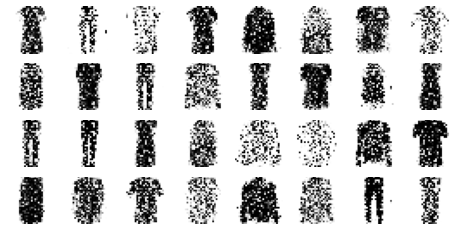

Epoch 2/20


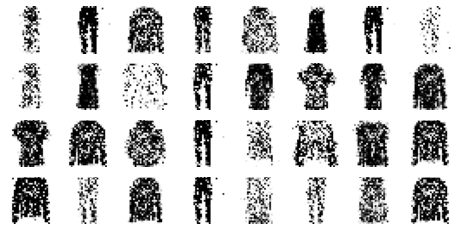

Epoch 3/20


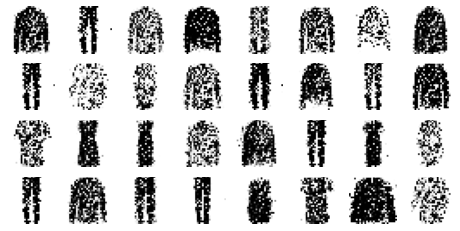

Epoch 4/20


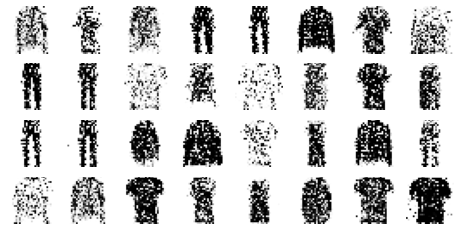

Epoch 5/20


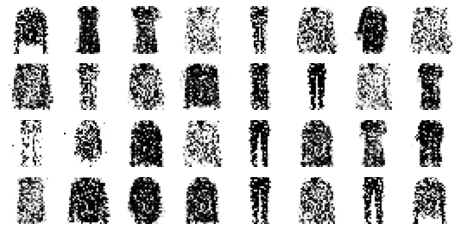

Epoch 6/20


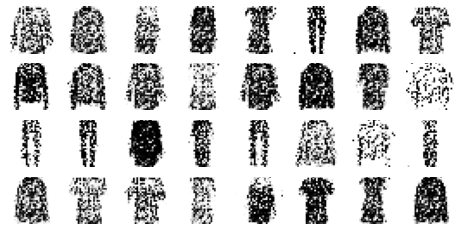

Epoch 7/20


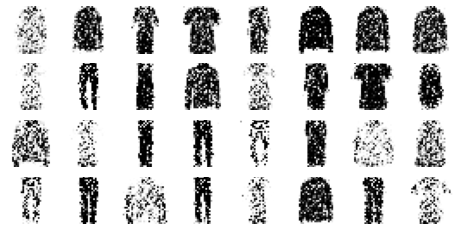

Epoch 8/20


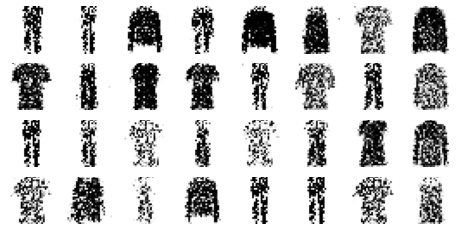

Epoch 9/20


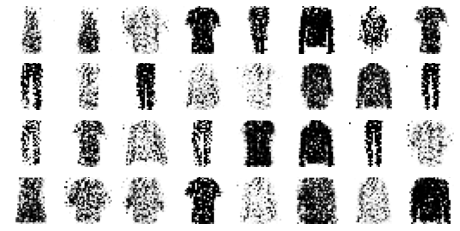

Epoch 10/20


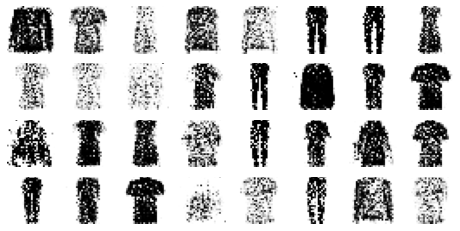

Epoch 11/20


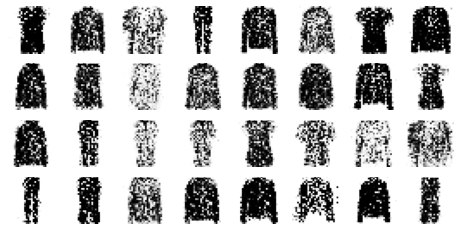

Epoch 12/20


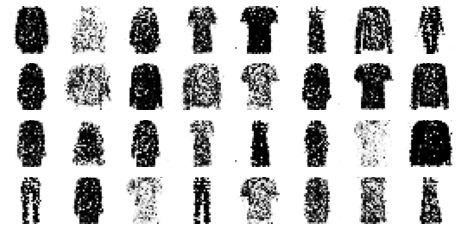

Epoch 13/20


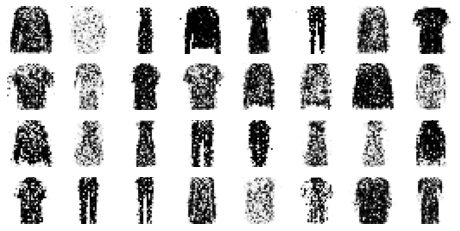

Epoch 14/20


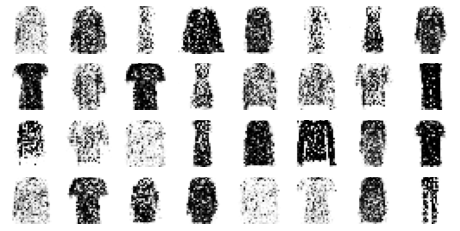

Epoch 15/20


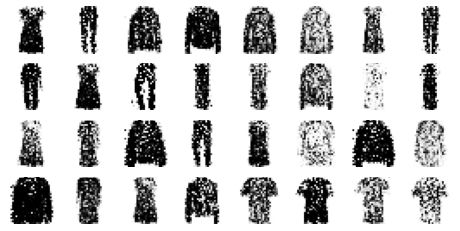

Epoch 16/20


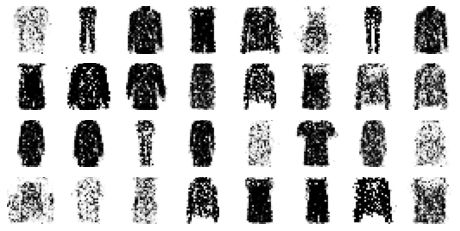

Epoch 17/20


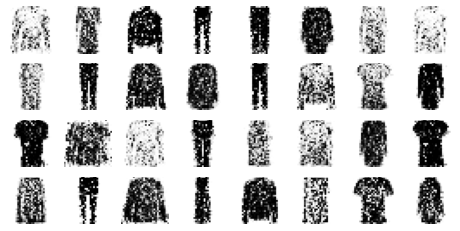

Epoch 18/20


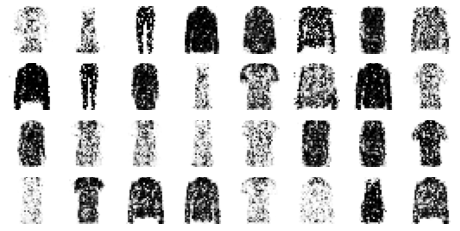

Epoch 19/20


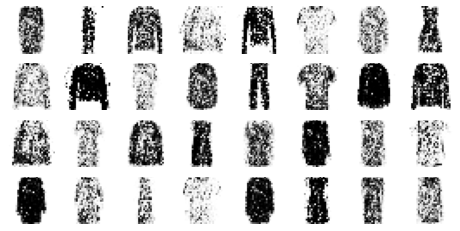

Epoch 20/20


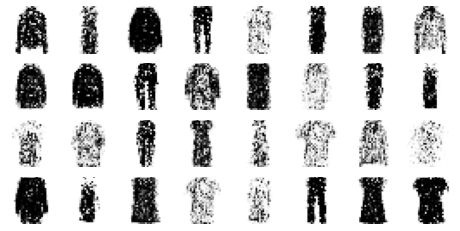

In [60]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs = 20 )